In [1]:
import tensorflow as tf
from __future__ import print_function
import numpy as np


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def euclideanDistance(x, z):
    '''
    We vectorized the operation with matrix operations
    the ||x - z ||^2 is = Sum(x - z)^2 = Sum from 1 to D
    of (x^2 - 2xz + z^2)
    
    x^2 = x^T times x
    z^2 = z^T times z
    we can find the sum of each row by using the reduce sum function
    
    sum of -2xz 
    we can use matrix multiplication, x times z^T to obtain xz,
    then multiply by -2
    '''
    n1 = x.shape[0]
    n2 = z.shape[0]    
    
    x_squared = tf.square(x)
    z_squared = tf.square(z) #tf.matmul(z ,tf.transpose(z))
 
    x_2_sum = tf.reduce_sum(x_squared, 1)
    z_2_sum = tf.reduce_sum(z_squared, 1)
    
    x_2_sum = tf.transpose(x_2_sum)
    z_2_sum = tf.transpose(z_2_sum)

    xz = tf.matmul(x, tf.transpose(z))
    minus_2xz = tf.scalar_mul(-2, xz)

 
    x_2_tile =tf.tile(tf.expand_dims(x_2_sum, 1), [1, n2])
    z_2_tile = tf.tile(tf.expand_dims(z_2_sum ,1), [1, n1])
    z_2_tile_T = tf.transpose(z_2_tile)

    result = x_2_tile + minus_2xz +z_2_tile_T
    
    return result

    

In [3]:
#given starter code
import numpy as np
import matplotlib.pyplot as plt

# my code part1 responsibility
def nearestIndices(_dist_mat, _k):

    nearest_k_data, nearest_k_indices = tf.nn.top_k(tf.negative(_dist_mat), _k)
    return nearest_k_data, nearest_k_indices


In [4]:
def pairDist(_data, _data1):
    data_t = tf.convert_to_tensor(_data)
    data1_t = tf.convert_to_tensor(_data1)
    dist = euclideanDistance(data_t, data1_t)
    return dist
  

def knn(_trainData, _trainTarget, _new_data, _k):
    '''
    KNN using responsibility
    '''
    #nearest indices
    dist_mat = pairDist( _new_data, _trainData )    
    nearest_k, nearest_k_idx = nearestIndices(dist_mat, _k)
    predict_res = tf.reduce_mean(tf.gather(_trainTarget, nearest_k_idx), 1)
    return predict_res




In [5]:
def plotResult(_trainData, _trainTarget):
    X = np.linspace(0.0, 11.0, num = 100)[:, np.newaxis]
    xTensor = tf.stack(X)
    
    num_neighbour_list = [1, 3, 5, 50]
    for j in num_neighbour_list:
        print("plot result")
        dist_mat = pairDist( X, _trainData ) 
        nearest_k, nearest_k_idx = nearestIndices(dist_mat, j)
        predict_res = tf.reduce_mean(tf.gather(_trainTarget, nearest_k_idx), 1)

        plt.figure()
        #plt.scatter(sessMain.run(_trainData), sessMain.run(_trainTarget))
        plt.scatter(_trainData.eval(), _trainTarget.eval())

        plt.title("K = " + str(j))
        plt.plot(xTensor.eval(), predict_res.eval())
        
        fileName = str("KNN") + str(j) + str("trainingGraph.png")
        plt.savefig(fileName)


In [6]:
def testKValuesKNN(trainData, trainTarget, testData, testTarget):
    num_neighbour_list = [1, 3, 5, 50]
    loss_list = []

    for j in num_neighbour_list:
        y_hat = knn(trainData, trainTarget, testData,  j)      
        mse_mat = tf.square(tf.subtract(y_hat, testTarget))
        loss = tf.reduce_mean(mse_mat)/2.0
        print("q1 neighbour = " ,j)
        loss_list.append(loss.eval())
    return loss_list
        

In [7]:
def q1():
    np.random.seed(521)
    Data = np.linspace(1.0 , 10.0 , num =100) [:, np. newaxis]
    Target = np.sin( Data ) + 0.1 * np.power( Data , 2) \
         + 0.5 * np.random.randn(100 , 1)
    randIdx = np.arange(100)
    np.random.shuffle(randIdx)
    trainData, trainTarget  = Data[randIdx[:80]], Target[randIdx[:80]]
    validData, validTarget = Data[randIdx[80:90]], Target[randIdx[80:90]]
    testData, testTarget = Data[randIdx[90:100]], Target[randIdx[90:100]]

    # convert numpy array to tensors
    trainData = tf.stack(trainData)
    trainTarget = tf.stack(trainTarget)
    testData = tf.stack(testData)
    testTarget = tf.stack(testTarget)
    validData = tf.stack(validData)
    validtarget = tf.stack(validTarget)
    
    print("********** BEGIN Q1 ***********")
    
    plotResult(trainData, trainTarget)
    
    loss_test = testKValuesKNN(trainData, trainTarget, testData, testTarget)
    print("q1 loss_test", loss_test)
    
    loss_train = testKValuesKNN(trainData, trainTarget, trainData, trainTarget)
    print("q1 loss_train" , loss_train)
    
    loss_valid = testKValuesKNN(trainData, trainTarget, validData, validTarget)
    print("q1 loss_valid", loss_valid)
    print("********** END Q1 ***********")

In [8]:
def data_segmentation(data_path, target_path, task):
    # task = 0 >> select the name ID targets for face recognition task
    # task = 1 >> select the gender ID targets for gender recognition task data = np.load(data_path)/255
    data = np.load(data_path)/255
    data = np.reshape(data, [-1, 32*32])
    target = np.load(target_path)
    np.random.seed(45689)
    rnd_idx = np.arange(np.shape(data)[0])
    np.random.shuffle(rnd_idx)
    trBatch = int(0.8*len(rnd_idx))
    validBatch = int(0.1*len(rnd_idx))
    trainData, validData, testData = data[rnd_idx[1:trBatch],:], \
                                   data[rnd_idx[trBatch+1:trBatch + validBatch],:],\
                                   data[rnd_idx[trBatch + validBatch+1:-1],:]
    trainTarget, validTarget, testTarget = target[rnd_idx[1:trBatch], task], \
                              target[rnd_idx[trBatch+1:trBatch + validBatch], task],\
                              target[rnd_idx[trBatch + validBatch + 1:-1], task]
    #print("train data dim", trainData.shape, "valid data dim", validData.shape,
             #"test data dim", testData.shape, "trainTarget shape", trainTarget.shape,
             #"validTarget SHAPE", validTarget.shape, "testTarget shape", testTarget.shape)
    return trainData, validData, testData, trainTarget, validTarget, testTarget


In [9]:
dum_tensor = tf.constant(0)



def plot_k10(_test_img, _neighbour_img):
    test_img = _test_img.eval()
    test_img = np.reshape(test_img, [32, 32] )
    plt.imshow(test_img, cmap='gray')
    plt.title("Confusion image")
    plt.show()


    neighbour_img = _neighbour_img.eval()
    n_count = 10 #10 neightbours
    # i: index
    for i in range(n_count):
        curr_img = np.reshape(neighbour_img[i,:], [32, 32] ) 
        plt.imshow(curr_img,  cmap='gray' )
        plt.title("Neighbours")
        plt.show()

    return dum_tensor

In [10]:
def knnVote(_trainData, _trainTarget, _new_data, _new_target, _k):
    '''
    KNN using majority vote
    '''
    #nearest indices
    dist_mat = pairDist( _new_data, _trainData ) 
    
    nearest_k, nearest_k_idx = nearestIndices(dist_mat, _k)
    neighbours = tf.gather(_trainTarget, nearest_k_idx)
    
    s1 = neighbours.shape[0]
    n_unstack = tf.unstack(neighbours, axis = 0)

    nearest_k_y, idx, votes = [], [], []
    predict_res = []
    cnt = 0 #only display 1 failure case
    i_idx = 0 #for tracking index for k=10 case
    for i in n_unstack:
        y, i, v = tf.unique_with_counts(i) 
        nearest_k_y.append(y)
        idx.append(i)
        votes.append(v)
        predict_res.append(y[tf.argmax(v)])
        votes.append(tf.argmax(v)) #record the indices chosen     
        
        # plotting for part 2
        if _k == 10 and cnt == 0:
            #neighbout image
            print("********* test images ***********")
            cnt += 1
            curr_test_target = tf.cast(_new_target[i_idx], tf.uint8)
            curr_test_data = tf.gather(_new_data, i_idx)
            curr_neighbour = tf.gather(_trainData, nearest_k_idx[1])
            plot_confusion = tf.cond(tf.not_equal(y[tf.argmax(v)], curr_test_target),
                    lambda: plot_k10(curr_test_data, curr_neighbour), lambda: dum_tensor )                   
        i_idx += 1
        
    predict_res = tf.convert_to_tensor(predict_res)
    return predict_res


In [11]:
def testQ2KNN(trainData, trainTarget, testData, testTarget):
    num_neighbour_list = [1, 5, 10, 25, 50, 100, 200]
    loss_list = []
    for j in num_neighbour_list:
        #print("running knn, k = ", j)
        y_hat = knnVote(trainData, trainTarget, testData, testTarget, j)
        y_hat = tf.cast(y_hat, tf.float16)
        testTarget = tf.cast(testTarget, tf.float16)
        # all the indices where y = target, bool
        loss = tf.not_equal(y_hat, testTarget )
        #cast bool to int
        as_ints = tf.cast(loss, tf.int32)
        error = tf.reduce_sum(as_ints)
        loss_list.append(error.eval())
    return loss_list


In [ ]:
def q2Task(t):
    data_path = '/Users/vikuo/Documents/GitHub/ece521/assi/A1/data/data.npy'
    target_path = '/Users/vikuo/Documents/GitHub/ece521/assi/A1/data/target.npy'
    trainData, validData, testData, trainTarget, validTarget, testTarget = data_segmentation(data_path, target_path, t)
       
    # convert numpy array to tensors
    trainData = tf.stack(trainData)
    trainTarget = tf.stack(trainTarget)
    testData = tf.stack(testData)
    testTarget = tf.stack(testTarget)
    validData = tf.stack(validData)
    validtarget = tf.stack(validTarget)
    
    print("********** BEGIN Q2 task ", t, " ***********")
    print("********** training *********")
    loss_train = testQ2KNN(trainData, trainTarget, trainData, trainTarget) 
    print("********** validating *********")
    loss_valid = testQ2KNN(trainData, trainTarget, validData, validTarget)
    
    print("********* testing *********")
    loss_test = testQ2KNN(trainData, trainTarget, testData, testTarget)
    

    
    print("q2 task", t, "loss train", loss_train)
    print("q2 task", t,  "loss test", loss_test)
    print("q2 task", t , "loss valid", loss_valid)
    print("********** END Q2 task ", t, " ***********")



********** BEGIN Q2 task  0  ***********
********** training *********
********* test images ***********


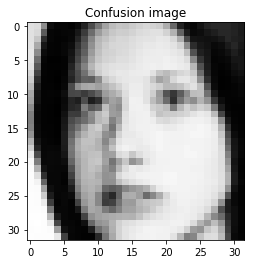

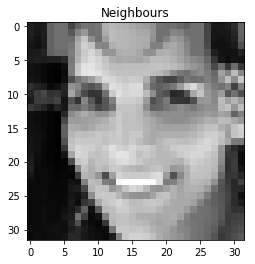

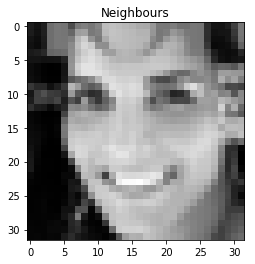

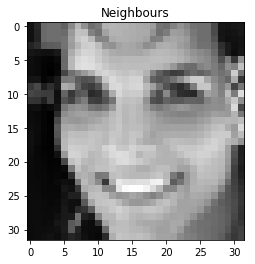

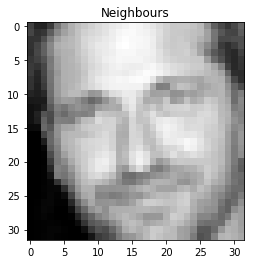

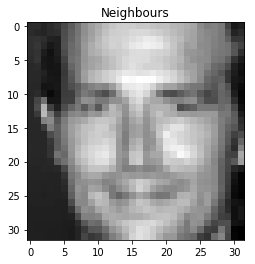

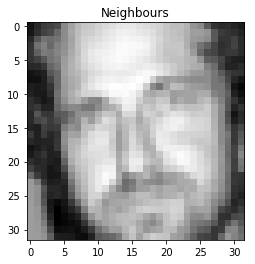

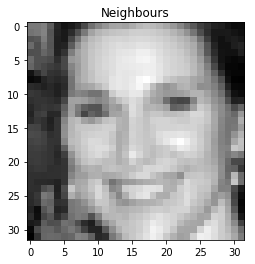

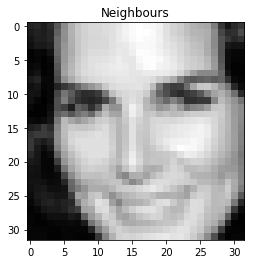

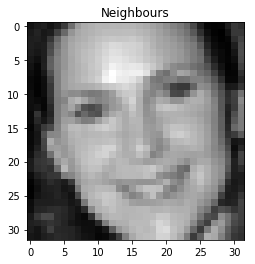

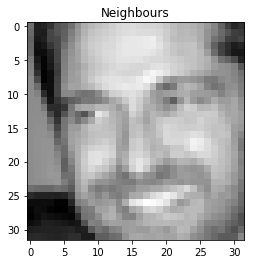

********** validating *********
********* test images ***********


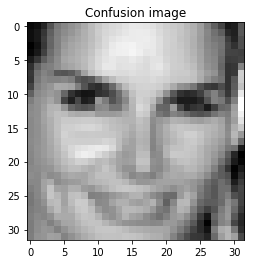

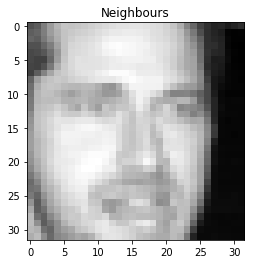

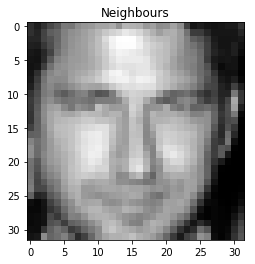

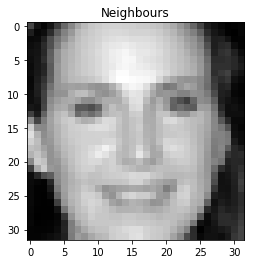

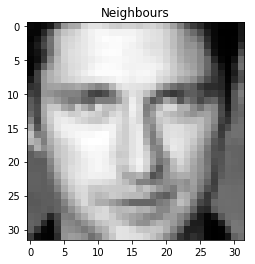

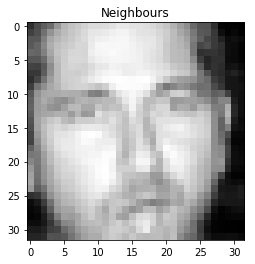

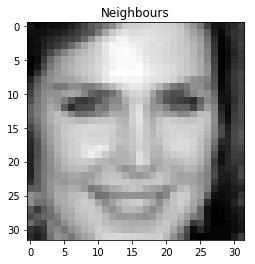

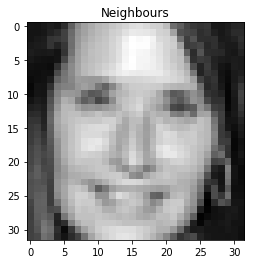

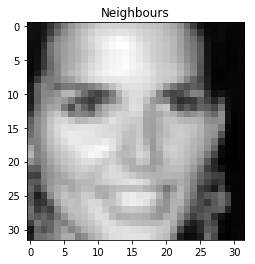

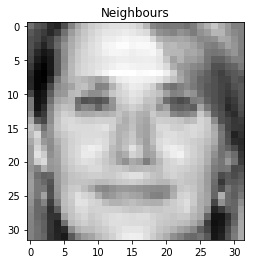

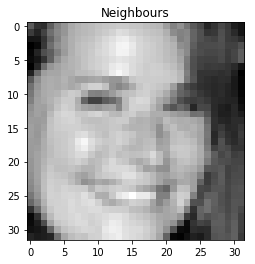

********* testing *********
********* test images ***********


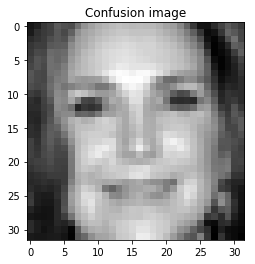

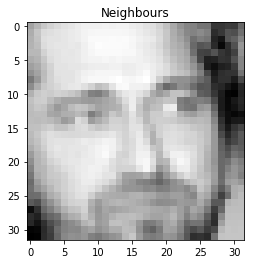

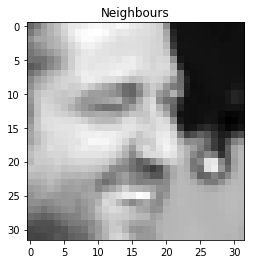

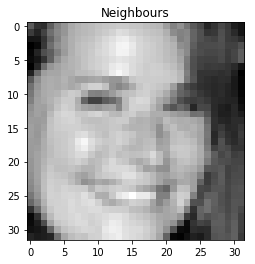

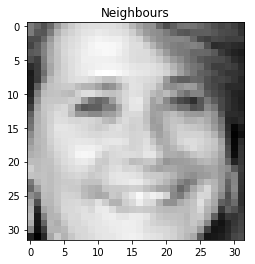

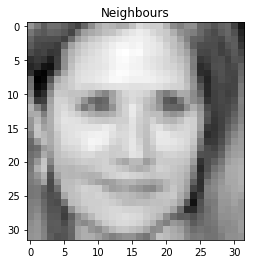

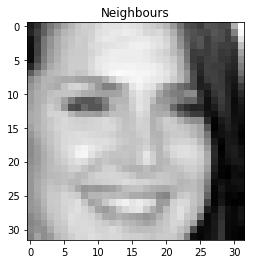

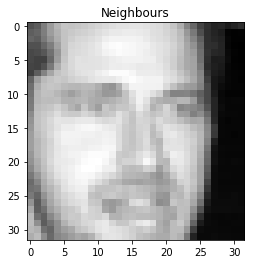

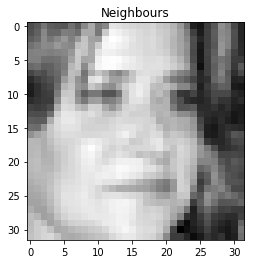

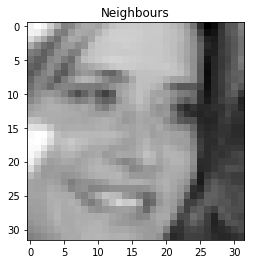

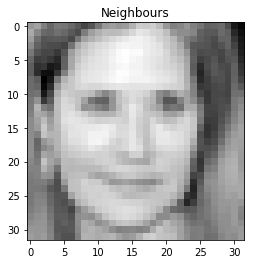

q2 task 0 loss train [0, 148, 206, 253, 308, 358, 428]
q2 task 0 loss test [27, 29, 31, 32, 39, 47, 56]
q2 task 0 loss valid [31, 36, 39, 37, 39, 48, 63]
********** END Q2 task  0  ***********
********** BEGIN Q2 task  1  ***********
********** training *********
********* test images ***********


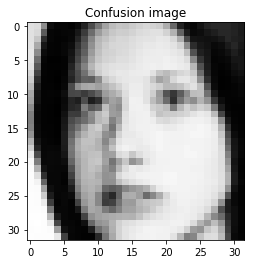

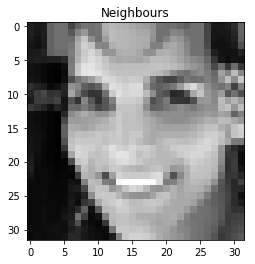

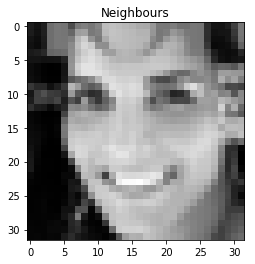

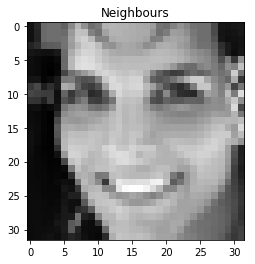

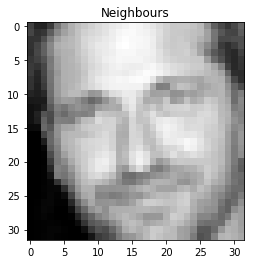

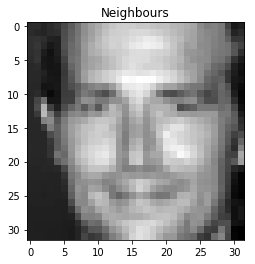

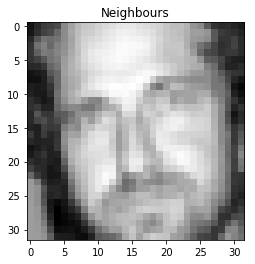

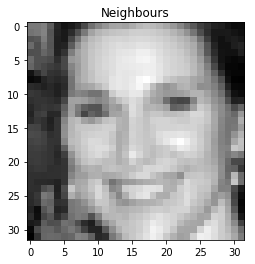

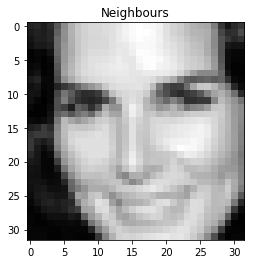

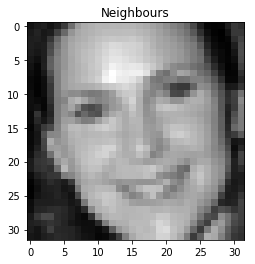

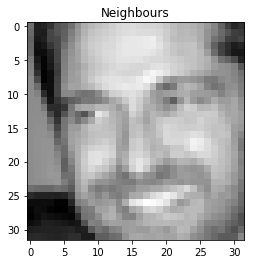

********** validating *********
********* test images ***********


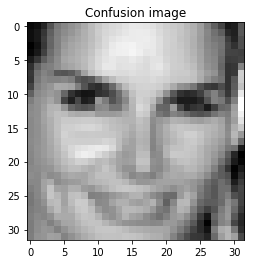

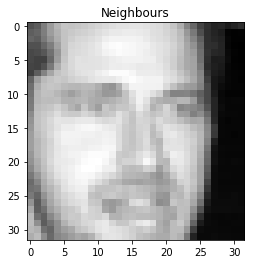

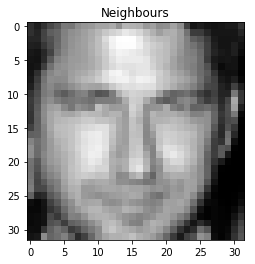

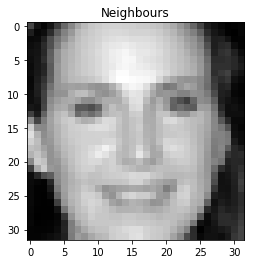

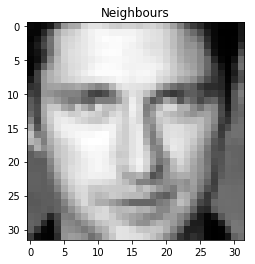

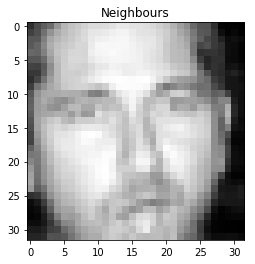

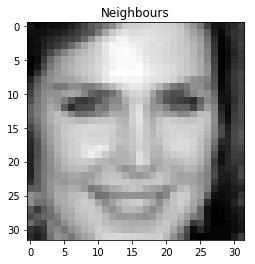

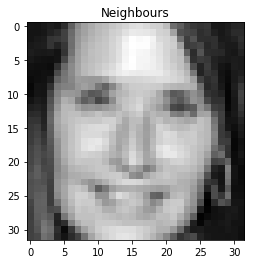

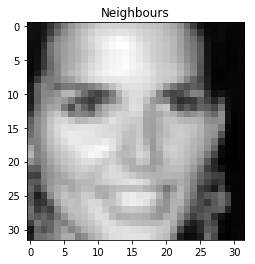

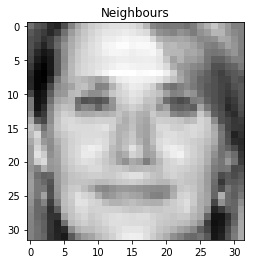

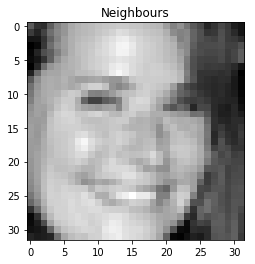

********* testing *********
********* test images ***********


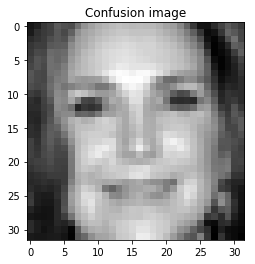

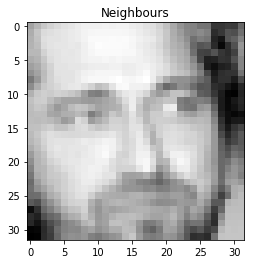

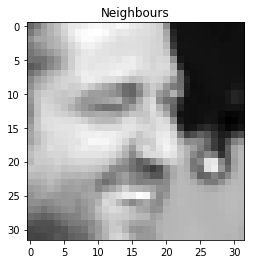

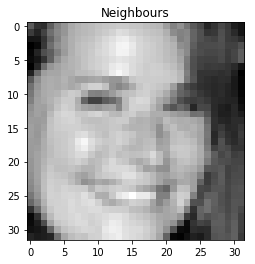

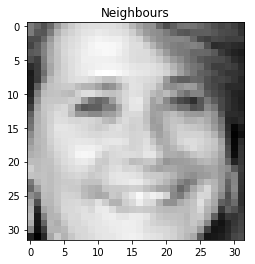

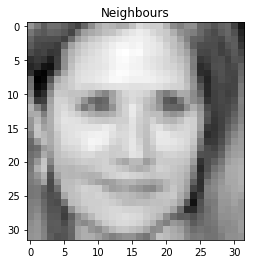

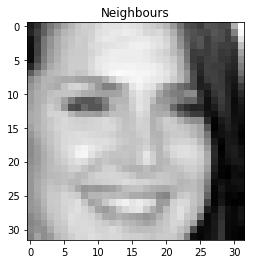

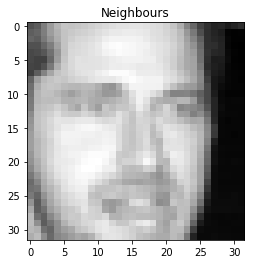

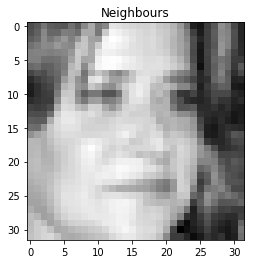

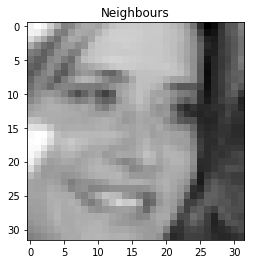

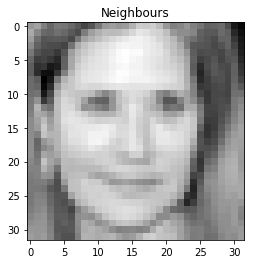

In [ ]:
from scipy import spatial as sp
from sklearn import metrics as skm


if __name__ == "__main__":
    
    init = tf.global_variables_initializer()
    sessMain = tf.InteractiveSession()
    sessMain.run(init)
    
    # NOTE FOR TAs:
    # uncomment next line if you want to run question 1 part 1 and 2
    #q1() 
    
    # NOTE FOR TAs:
    #modify the data_path and target_path in def q2Task(t)
    q2Task(0)
    q2Task(1)
    
    
    
    



        